In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '../t-recs/')
from trecs.metrics import Measurement
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, top_k_reranking
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_73579/2185722975.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
def plot_user_mse(dfs, parameters, train_timesteps=0):
    fig = plt.figure(figsize=(8, 5))
    fig.tight_layout(pad=5.0)
    # overlapping = 0.75
    alpha = 0.75
    
    timesteps = np.arange(dfs[0].shape[1] - train_timesteps)
    print(timesteps[0::10])

    # plot rec_similarity with timesteps on x axis
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        
        cluster_mse = df.iloc[:, train_timesteps:].groupby(['clusterID']).mean()
        worst_user_cluster = cluster_mse.mean(axis=1).idxmax()
        mse_diff = abs(cluster_mse.mean() - worst_user_cluster)
        # print("avg. MSE = ", cluster_mse.mean()[-1])
        # print("worst cluster MSE = ", worst_user_cluster)
        # print("diff MSE = ", mse_diff[-1])
        
        plt.plot(mse_diff, label = f"{parameters[i][0]}, worst user cluster:{worst_user_cluster}", alpha=alpha)
    # plt.plot(cluster_mse.loc[worst_user_cluster], label = f"cluster {worst_user_cluster} MSE")
    plt.title('Difference in Avg. MSE and Worst-User Cluster MSE')
    plt.xlabel("Timestep")
    plt.ylabel("Delta MSE")
    plt.xticks(timesteps[0::10])
    plt.legend()
    
    plt.savefig('figures/user_mse_analysis.png')
        
    fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

In [3]:
path_user_mse_histogram = 'artefacts/supplementary/measurements/mse_histograms/cosine_sim_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv'
df_user_mse = pd.read_csv(path_user_mse_histogram)
df_user_mse

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,clusterID
0,0.035123,0.042399,0.047155,0.051848,0.054188,0.058816,0.067480,0.070468,0.074638,0.081893,...,0.098127,0.091297,0.085401,0.081653,0.082066,0.083945,0.084017,0.080980,0.086413,9
1,0.081768,0.086721,0.095618,0.104239,0.106331,0.115483,0.122359,0.130227,0.141123,0.147803,...,0.107563,0.104718,0.109270,0.119418,0.121833,0.127269,0.154742,0.153980,0.145857,18
2,0.161194,0.159959,0.158385,0.154309,0.149578,0.162175,0.166408,0.163395,0.162403,0.157654,...,0.101653,0.105781,0.106658,0.101864,0.096512,0.095667,0.097046,0.104779,0.111914,2
3,0.214970,0.229213,0.235777,0.234972,0.235391,0.237693,0.251476,0.247556,0.249238,0.262087,...,0.124058,0.122217,0.122697,0.119383,0.123148,0.123210,0.134796,0.130223,0.142841,7
4,0.018582,0.022736,0.027096,0.029015,0.033309,0.036363,0.041130,0.047941,0.051710,0.059893,...,0.132769,0.130997,0.124505,0.119781,0.117840,0.119519,0.121856,0.119194,0.114519,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.189920,0.194320,0.194120,0.191039,0.188804,0.190996,0.199216,0.199069,0.198029,0.203269,...,0.111380,0.111282,0.110142,0.115026,0.113184,0.125058,0.121665,0.119690,0.140161,7
939,0.085891,0.086230,0.086674,0.089747,0.091677,0.091733,0.094755,0.105719,0.119062,0.120559,...,0.134803,0.129848,0.134991,0.144149,0.153395,0.150169,0.145785,0.151596,0.153196,23
940,0.166822,0.166239,0.173399,0.178730,0.188612,0.184873,0.185405,0.189181,0.183538,0.188657,...,0.094343,0.090330,0.090517,0.087079,0.081648,0.078492,0.085755,0.086690,0.096149,7
941,0.086185,0.096438,0.100169,0.102442,0.106979,0.105896,0.110749,0.112685,0.112157,0.113363,...,0.106685,0.106766,0.100192,0.099389,0.096250,0.094652,0.092381,0.091863,0.095514,23


In [4]:
paths_user_mse = {
    'cosine_sim (λ=0.01)':'artefacts/supplementary/measurements/mse_histograms/cosine_sim_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.01Lambda.csv',
    'cosine_sim (λ=0.1)':'artefacts/supplementary/measurements/mse_histograms/cosine_sim_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv',
    'entropy (λ=0.1)':'artefacts/supplementary/measurements/mse_histograms/entropy_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv',
    'entropy (λ=1.0)':'artefacts/supplementary/measurements/mse_histograms/entropy_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv',
    # 'entropy (λ=10.0)':'artefacts/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10.0Lambda.csv',
    'top_k_reranking':'artefacts/supplementary/measurements/mse_histograms/top_k_reranking_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv',
    'myopic':'artefacts/supplementary/measurements/mse_histograms/myopic_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'
}

In [5]:
paths = [
    ('cosine_sim (λ=0.01)', paths_user_mse['cosine_sim (λ=0.01)']),
    ('cosine_sim (λ=0.1)', paths_user_mse['cosine_sim (λ=0.1)']),
    ('entropy (λ=0.1)', paths_user_mse['entropy (λ=0.1)']),
    ('entropy (λ=1.0)', paths_user_mse['entropy (λ=1.0)']),
    # ('entropy (λ=10.0)', paths_user_mse['entropy (λ=10.0)']),
    ('top_k_reranking', paths_user_mse['top_k_reranking']),
    ('myopic', paths_user_mse['myopic'])
]

dfs_user_mse = []
for i in paths:
    print(i[1])
    df = pd.read_csv(i[1])
    dfs_user_mse.append(df)

artefacts/supplementary/measurements/mse_histograms/cosine_sim_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.01Lambda.csv
artefacts/supplementary/measurements/mse_histograms/cosine_sim_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv
artefacts/supplementary/measurements/mse_histograms/entropy_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv
artefacts/supplementary/measurements/mse_histograms/entropy_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv
artefacts/supplementary/measurements/mse_histograms/top_k_reranking_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv
artefacts/supplementary/measurements/mse_histograms/myopic_user_mse_histogram_10trainTimesteps_100runTimesteps_20nAttrs_25nCl

In [6]:
# dfs_user_mse[0]

[  0  10  20  30  40  50  60  70  80  90 100 110]


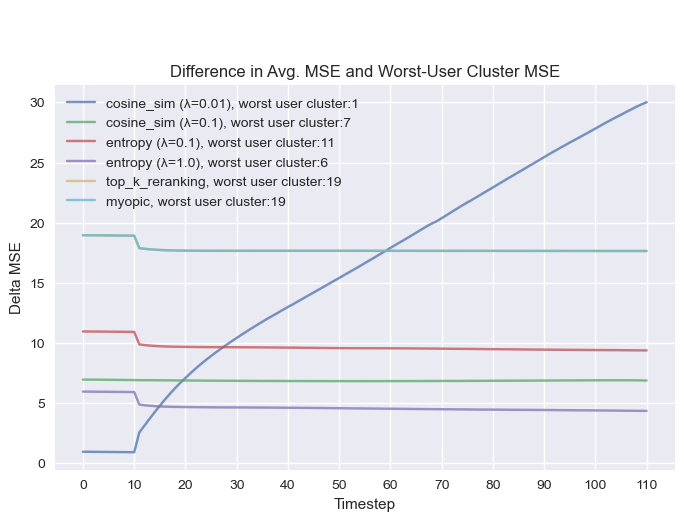

In [7]:
plot_user_mse(dfs_user_mse, paths)